<font size="+3"><strong>Clustering with Two Features</strong></font>

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from teaching_tools.widgets import ClusterWidget, SCFClusterWidget

# Prepare Data

## Import

Just like always, we need to begin by bringing our data into the project. We spent some time in the previous lesson working with a subset of the larger SCF dataset called `"TURNFEAR"`. Let's start with that.

In [5]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    mask = df["TURNFEAR"] == 1
    df = df[mask]
    return df

In [16]:
df = wrangle("SCFP2019.csv")
print(df.shape)
df.head()

(4623, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


## Explore

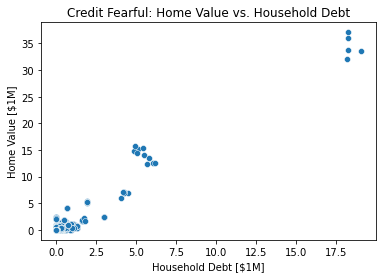

In [17]:
# Plot "HOUSES" vs "DEBT"
sns.scatterplot(x=df["DEBT"]/1e6, y=df["HOUSES"]/1e6)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

Remember that graph and its clusters? Let's get a little deeper into it.

## Split

We need to split our data, but we're not going to need target vector or a test set this time around. That's because the model we'll be building involves *unsupervised* learning. It's called *unsupervised* because the model doesn't try to map input to a st of labels or targets that already exist. It's kind of like how humans learn new skills, in that we don't always have models to copy. Sometimes, we just try out something and see what happens. Keep in mind that this doesn't make these models any less useful, it just makes them different.

So, keeping that in mind, let's do the split.

In [18]:
X = df[["DEBT", "HOUSES"]]
print(X.shape)
X.head()

(4623, 2)


,DEBT,HOUSES
5,12200.0,0.0
6,12600.0,0.0
7,15300.0,0.0
8,14100.0,0.0
9,15400.0,0.0


# Build Model

In [39]:
cw = ClusterWidget(n_clusters=3)
cw.show()

Since a centroid represents the mean value of all the data in the cluster, we would expect it to fall in the center of whatever cluster it's in. That's what will happen if you move the slider one more position to the right. See how the centroids moved? 

In [40]:
scfc = SCFClusterWidget(x=df["DEBT"], y=df["HOUSES"], n_clusters=3)
scfc.show()

## Iterate

In [41]:
# Build model
model = KMeans(n_clusters=3, random_state=42)
# Fit model to data
model.fit(X)

KMeans(n_clusters=3, random_state=42)

And there it is. 42 datapoints spread across three clusters. Let's grab the labels that the model has assigned to the data points so we can start making a new visualization.

In [42]:
labels = model.labels_
labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Using the labels we just extracted, let's recreate the scatter plot from before, this time we'll color each point according to the cluster to which the model assigned it.

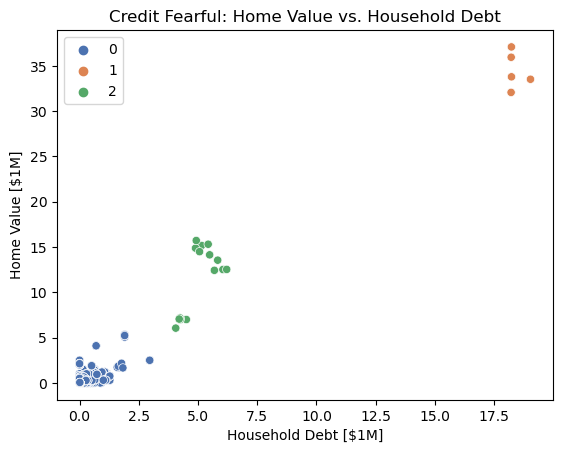

In [43]:
# Plot "HOUSES" vs "DEBT" with hue=label
sns.scatterplot(
    x=df["DEBT"]/1e6,
    y=df["HOUSES"]/1e6,
    hue=labels,
    palette="deep"
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

Nice! Each cluster has its own color. The centroids are still missing, so let's pull those out.

In [44]:
centroids = model.cluster_centers_
centroids

array([[   91017.57766674,   116150.29328699],
       [18384100.        , 34484000.        ],
       [ 5065800.        , 11666666.66666667]])

Let's add the centroids to the graph.

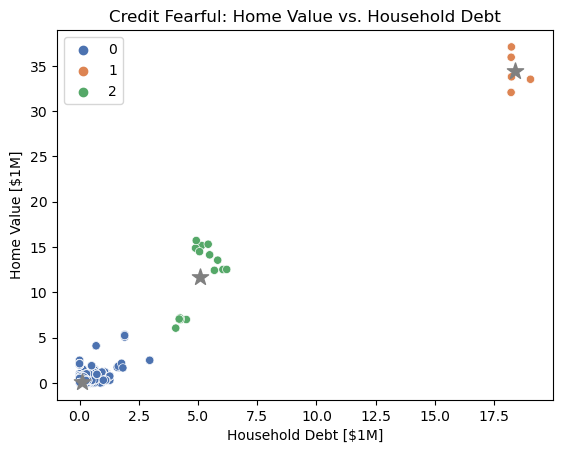

In [45]:
# Plot "HOUSES" vs "DEBT", add centroids
sns.scatterplot(
    x=df["DEBT"]/1e6,
    y=df["HOUSES"]/1e6,
    hue=labels,
    palette="deep"
)
plt.scatter(
    x=centroids[:, 0]/1e6,
    y=centroids[:, 1]/1e6,
    color="gray",
    marker="*",
    s=150
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

In [46]:
inertia = model.inertia_
print("Inertia (3 clusters):", inertia)

Inertia (3 clusters): 939554010797047.8


The "best" inertia is 0, and our score is pretty far from that. Does that mean our model is "bad?" Not necessarily. Inertia is a measurement of distance (like mean absolute error from Project 2). This means that the unit of measurement for inertia depends on the unit of measurement of our x- and y-axes. And since `"DEBT"` and `"HOUSES"` are measured in tens of millions of dollars, it's not surprising that inertia is so large. 

However, it would be helpful to have metric that was easier to interpret, and that's where **silhouette score** comes in. Silhouette score measures the distance *between different clusters*. It ranges from -1 (the worst) to 1 (the best), so it's easier to interpret than inertia. 

In [47]:
ss = silhouette_score(X, model.labels_)
print("Silhouette Score (3 clusters):", ss)

Silhouette Score (3 clusters): 0.9768842462944348


In [48]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = [] 

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertia_errors.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X, model.labels_))
print("Inertia:", inertia_errors)
print()
print("Silhouette Scores:", silhouette_scores)

Inertia: [3018038313336915.5, 939554010797047.8, 546098841715653.0, 309310386410919.4, 235243397481788.4, 182225729179699.5, 150670779013795.16, 114321995931020.88, 100340259483916.77, 86229997033602.4, 74757234072100.34]

Silhouette Scores: [0.9855099957519555, 0.9768842462944348, 0.9490311483406091, 0.839330043242819, 0.7287406719898627, 0.726989114305748, 0.7263840026889208, 0.7335125606476427, 0.692157992955073, 0.6949309528556856, 0.6951831031001252]


Now that we have both performance metrics for several different settings of `n_clusters`, let's make some line plots to see the relationship between the number of clusters in a model and its inertia and silhouette scores.

Text(0.5, 1.0, 'K-Means Model: Inertia vs Number of Clusters')

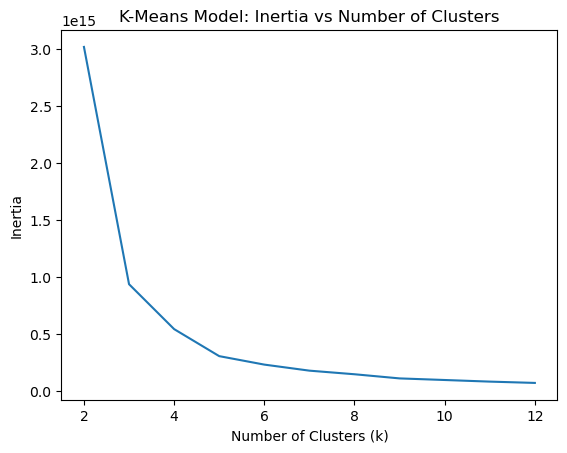

In [49]:
# Plot `inertia_errors` by `n_clusters`
plt.plot(n_clusters, inertia_errors)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("K-Means Model: Inertia vs Number of Clusters")

Text(0.5, 1.0, 'K-Means Model: Silhouette Score vs Number of Clusters')

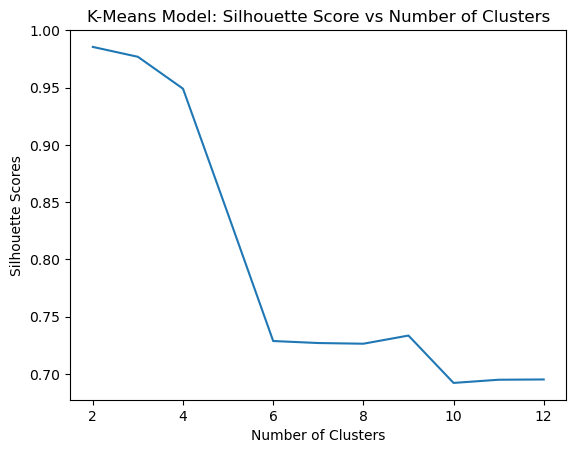

In [50]:
# Plot `silhouette_scores` vs `n_clusters`
plt.plot(n_clusters, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Scores")
plt.title("K-Means Model: Silhouette Score vs Number of Clusters")

In [51]:
# Build model
final_model = KMeans(n_clusters=4, random_state=42)
# Fit model to data4
final_model.fit(X)

KMeans(n_clusters=4, random_state=42)

(In case you're wondering, we don't need an *Evaluate* section in this notebook because we don't have any test data to evaluate our model with.)

# Communicate

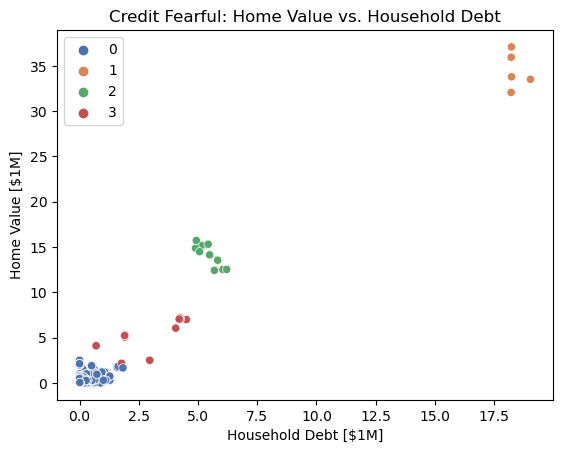

In [52]:
# Plot "HOUSES" vs "DEBT" with final_model labels
sns.scatterplot(
    x=df["DEBT"]/1e6,
    y=df["HOUSES"]/1e6,
    hue=final_model.labels_,
    palette="deep"
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

In [53]:
xgb = X.groupby(final_model.labels_).mean()
xgb

,DEBT,HOUSES
0,8.488629e+04,1.031872e+05
1,1.838410e+07,3.448400e+07
2,5.472800e+06,1.407400e+07
3,2.420929e+06,4.551429e+06


Before you move to the next task, print out the `cluster_centers_` for your `final_model`. Do you see any similarities between them and the DataFrame you just made? Why do you think that is?

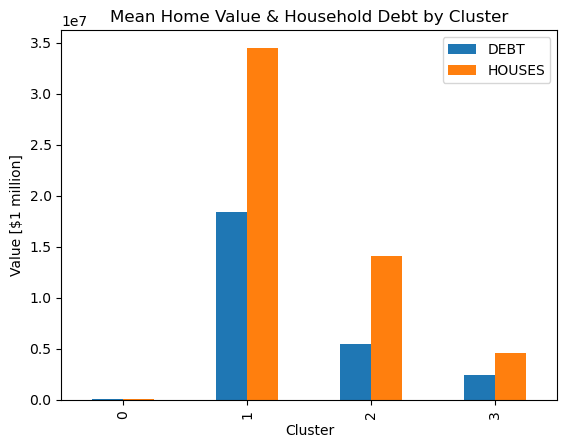

In [54]:
# Create side-by-side bar chart of `xgb`
(xgb).plot(kind="bar")
plt.xlabel("Cluster")
plt.ylabel("Value [$1 million]")
plt.title("Mean Home Value & Household Debt by Cluster");

<AxesSubplot:title={'center':'Proportion of Debt to Home value'}, xlabel='Cluster', ylabel='Proportion, Debt/Home'>

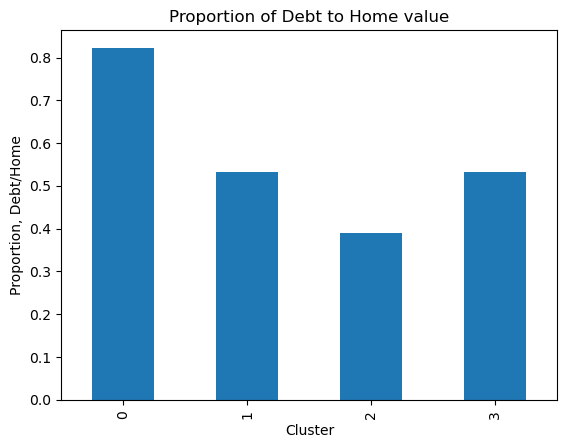

In [55]:
(xgb["DEBT"]/xgb["HOUSES"]).plot(
    kind="bar",
    xlabel="Cluster",
    ylabel="Proportion, Debt/Home",
    title="Proportion of Debt to Home value"
)

In this plot, we have our four clusters spread across the x-axis, and the dollar amounts for home value and household debt on the y-axis. 

The first thing to look at in this chart is the different mean home values for the five clusters. Clusters 0 represents households with small to moderate home values, clusters 2 and 3 have high home values, and cluster 1 has extremely high values. 

The second thing to look at is the proportion of debt to home value. In clusters 1 and 3, this proportion is around 0.5. This suggests that these groups have a moderate amount of untapped equity in their homes. But for group 0, it's almost 1, which suggests that the largest source of household debt is their mortgage. Group 2 is unique in that they have the smallest proportion of debt to home value, around 0.4.

This information could be useful to financial institution that want to target customers with products that would appeal to them. For instance, households in group 0 might be interested in refinancing their mortgage to lower their interest rate. Group 2 households could be interested in a [home equity line of credit](https://www.investopedia.com/home-equity-line-of-credit-heloc-definition-5217473) because they have more equity in their homes. And the bankers, Bill Gates, and Beyoncés in group 1 might want white-glove personalized wealth management. 